# Interpretación de música de piano usando técnicas de Deep Learning.
## Trabajo de Fin de Grado.
### Facultad de Ciencias - Universidad de Cantabria.
**Autor:** Álvaro López García. <br>
**Tutor:** Cristina Tirnauca.

In [4]:
# Celda para importar librerías, costantes, etc.
import tensorflow as tf
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
import mido
import math
import copy

from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# Para entrenarlo en mi equipor personal:
# PATH = '/Volumes/TheVault/Documentos Mac/Documentos Universidad/4o Curso/2o Cuatrimestre/Trabajo de Fin de Grado/maestro-v3.0.0/'
PATH = './maestro-v3.0.0/'

### Creación del dataframe

In [5]:
def get_dataframe(path=PATH + 'maestro-v3.0.0.csv'):
    df = pd.read_csv(path)
    return df

In [6]:
df = get_dataframe()
df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


## Clases, métodos y constantes para el procesado del Dataset

### Parámetros del procesado

In [7]:
# Parámetros de configuración de los archivos de audio
SAMPLING_RATE = 16000
N_NOTES = 88
N_ROWS = 1

# TO DO: Código provisional -> Quitar
if N_ROWS is not None:
    num = N_ROWS
else:
    num = len(df) - 1

### Métodos auxililares para manejar los objetos de la clase `tf.Data`

In [8]:
def get_items(bounds, data):
    
    min_, max_ = bounds
    result = []
    
    for idx, i in enumerate(data):
        if min_ <= idx < max_:
            result.append(i)
        if idx >= max_:
            return result
        
    return result

###  Código para el procesado de los datos relativos a los ficheros MIDI (`*.midi -> tf.Dataset`)

In [9]:
# Constantes relativas al estádar MIDI
DEFAULT_SR = 500000

In [10]:
from utils.midi_handler import Midi_handler
midi_hdlr = Midi_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH, n_notes=N_NOTES)

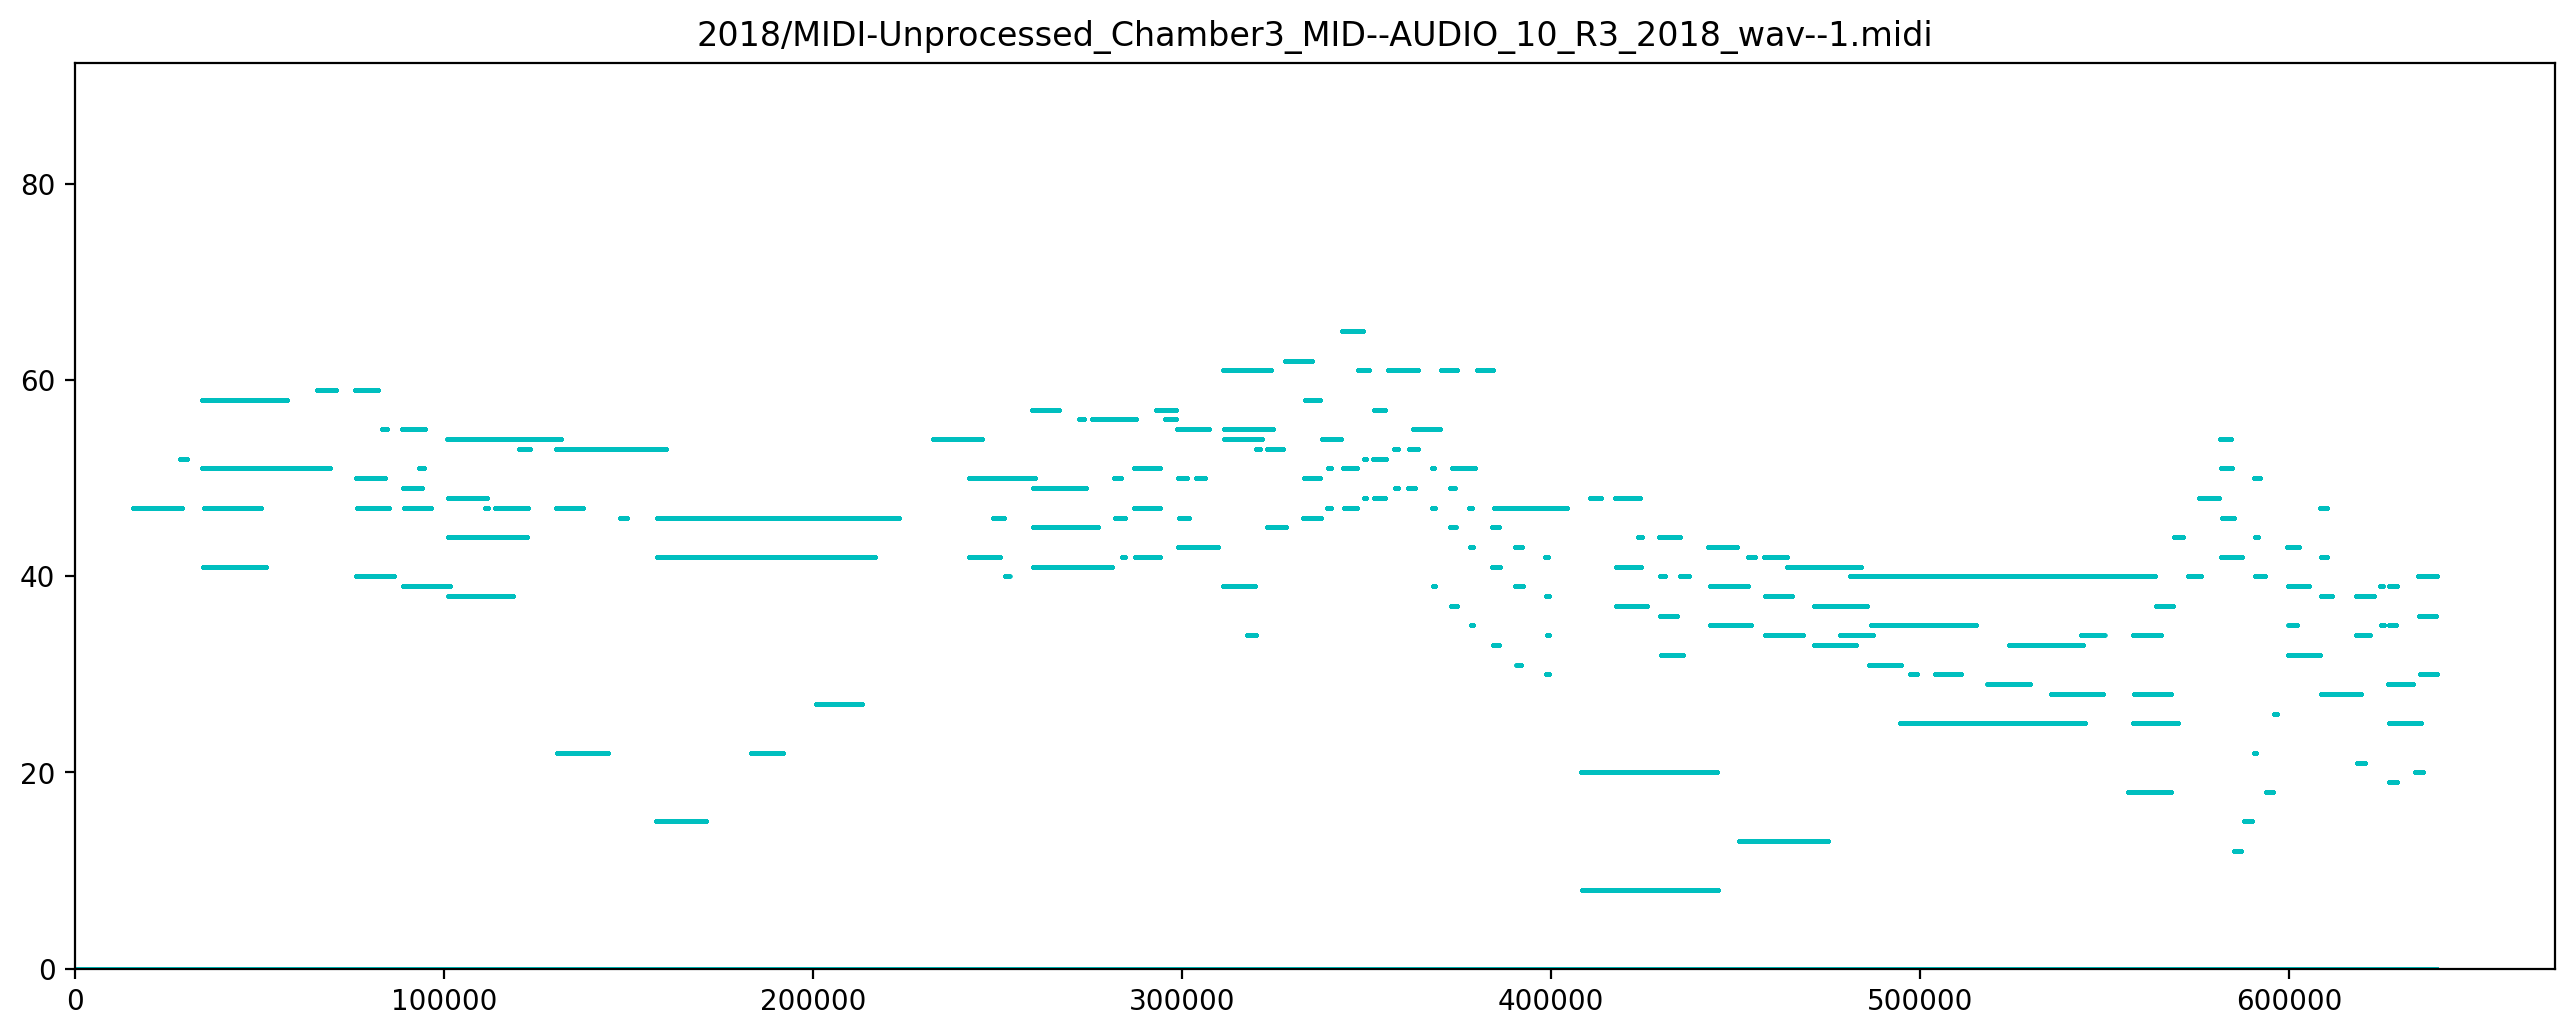

In [9]:
# Ploteamos una sección de un pianoroll de ejemplo
midi_hdlr.plot_pianoroll(midi_hdlr.vectorize_midi(df['midi_filename'][0])[0:640000], title=df['midi_filename'][0])

Para los datos relativos a los ficheros `.midi` aplicaremos la normalización **MinMax** donde cada nuevo valor $x'$ para cada ejemplo $x$ vendrá dado por: $$ x' = \frac{x - min}{max - min} ,$$ donde $max$ y $min$ son los valores máximos y mínimos de los valores de entrada. En este caso, dada la definición del estándar MIDI, sabemos que los valores de estas velocidades ya están parametrizados entre $0$ y $127$ por lo que no necesitamos iterar sobre los datos para conocer el máximo y el mínimo. Para ello definiremos las siguientes constantes:

In [11]:
# Constates para aplicar la normalización a los ficheros MIDI
MIDI_MAX = 127
MIDI_MIN = 0

### Código para el procesado de los datos relativos a los ficheros de audio (`*.wav -> tf.Dataset`)

In [12]:
from utils.wav_handler import Wav_handler
wav_hdlr = Wav_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH)

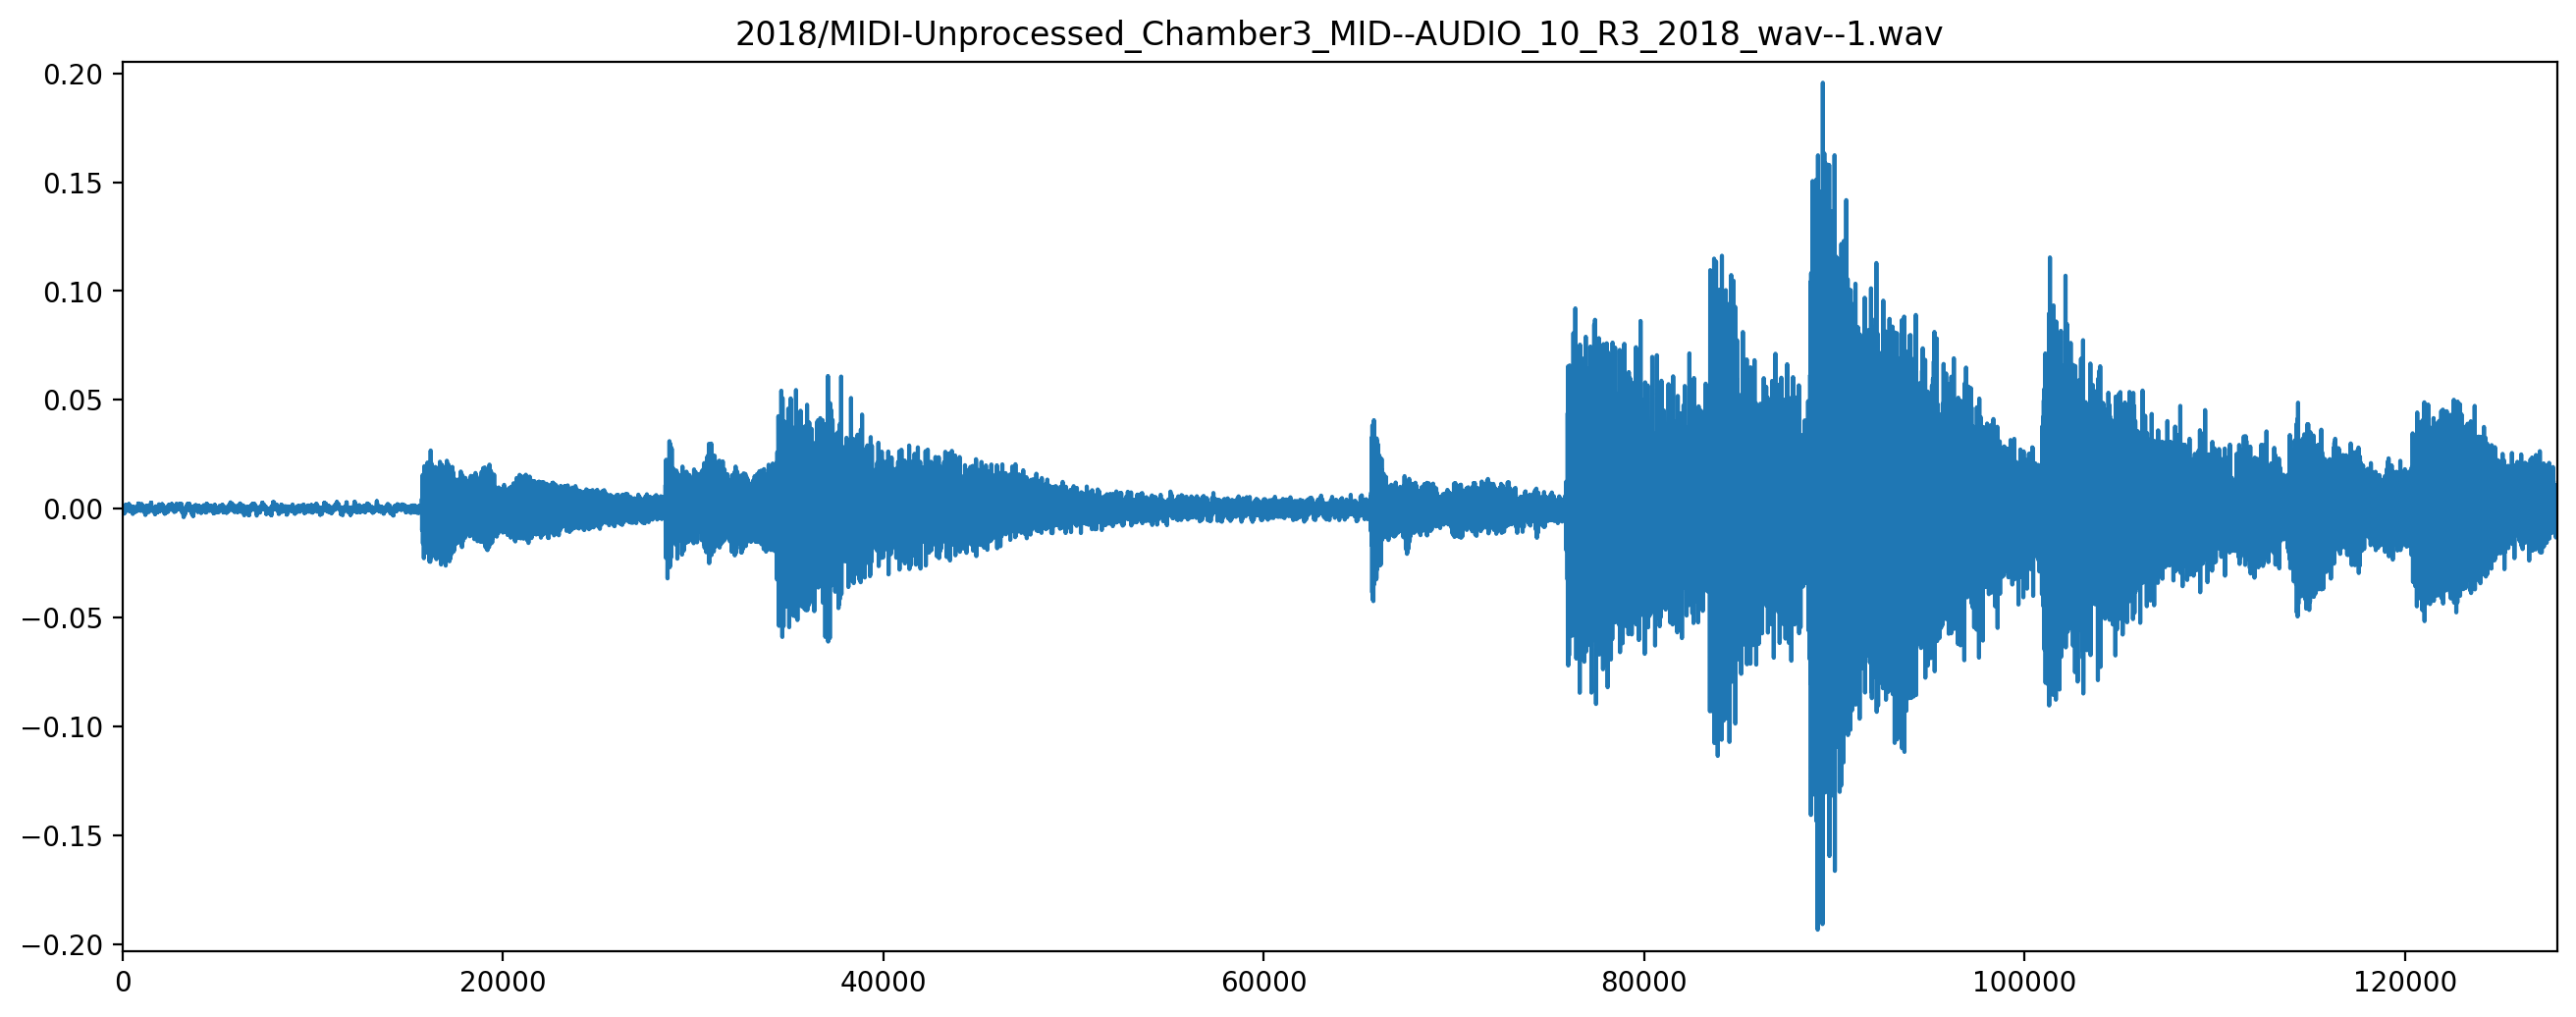

In [12]:
# Ploteamos una sección de una onda
wav_hdlr.plot_wav(wav_hdlr.vectorize_wav(df['audio_filename'][0])[0:128000], title=df['audio_filename'][0])

Para la compresión de la señal emplearemos una compresión basada en una $\mu$-law TO DO: Explicar más

In [13]:
# Constates relativas a la compresión con la mu-law
N_BITS = 8
N_LEVELS = 2 ** N_BITS
MU = 256
AMPS = (-1, 1)

In [14]:
from utils.mu_law_encoder import Mu_law_encoder
mulaw_enc = Mu_law_encoder(mu=MU, n_bits=N_BITS, amps=AMPS)

## Creación del modelo
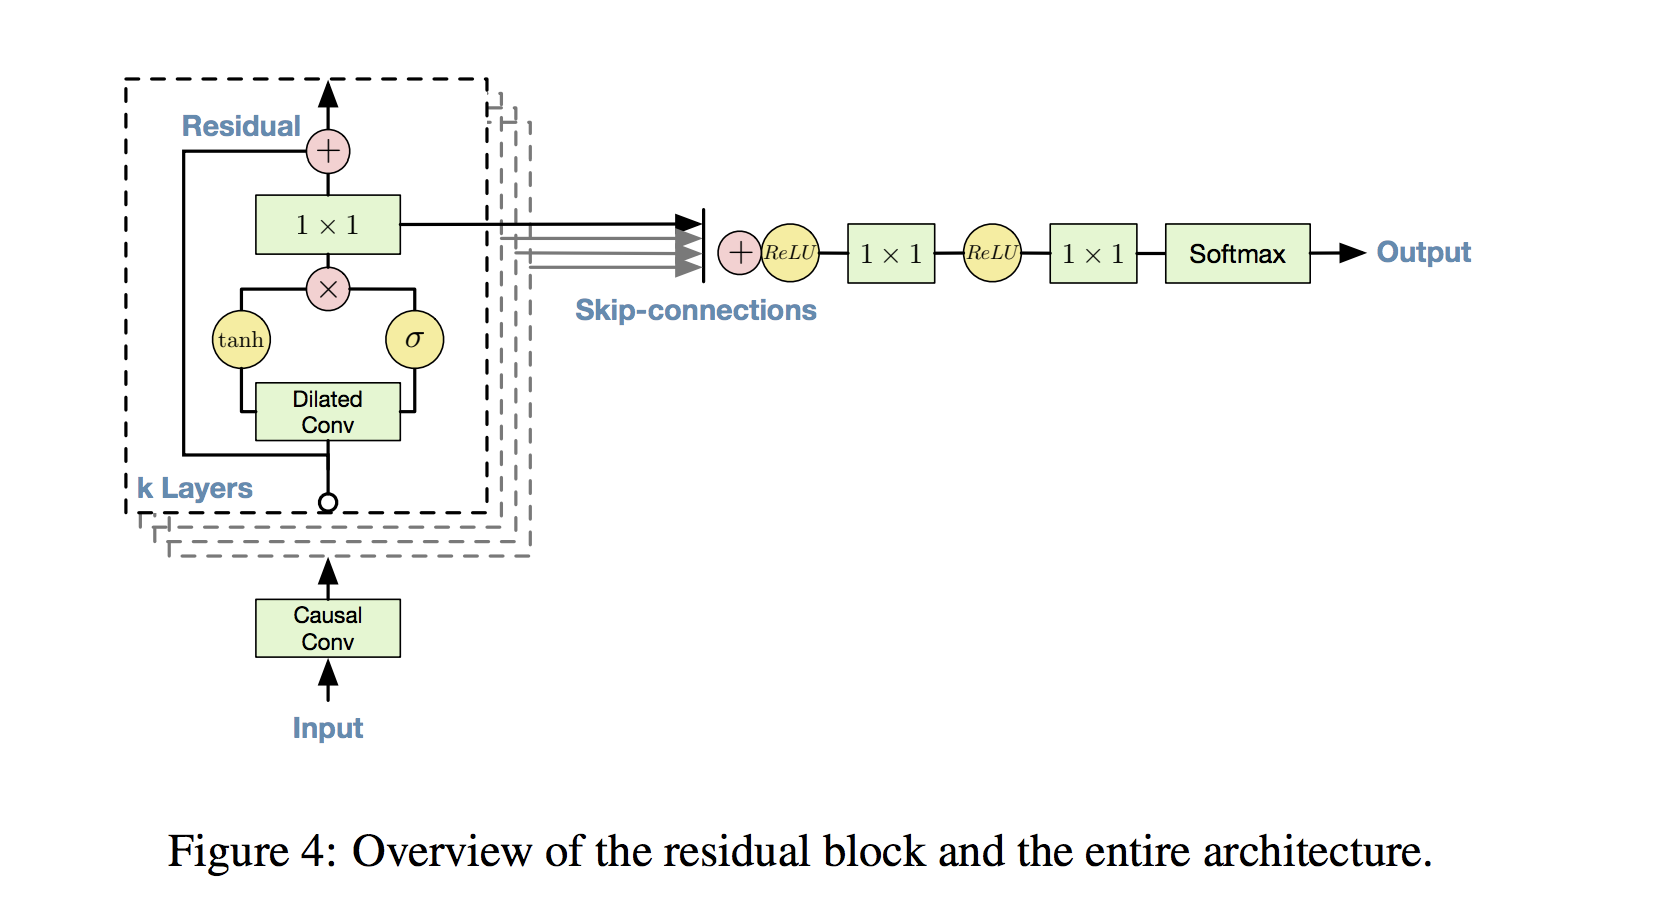

<div>
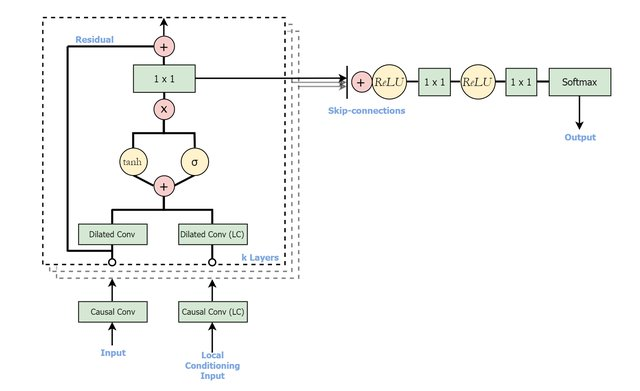
</div>

In [15]:
def calculate_receptive_field(n_blocks, n_layers):
    return sum([2 ** i for i in range(n_layers)] * n_blocks) - n_blocks + 1

In [16]:
# Parámetros que definen la arquitectura del modelo a crear por defecto en las llamadas a get_wavenet()

# Parámetros de la arquitectura interna de la red
N_FILTERS = N_LEVELS
FILTER_WIDTH = 2
N_BLOCKS = 3
K_LAYERS = 9

# Números y longitudes de ejemplos de entrada, salida y local conditioning
INPUT_LEN = calculate_receptive_field(N_BLOCKS, K_LAYERS)
N_IN_CHANNELS = N_LEVELS
LC_LEN = 1
N_LC_CHANNELS = N_NOTES

# Dimensionalidad de input/output/local conditioning
INP_SHAPE = (INPUT_LEN, N_IN_CHANNELS)
OUT_SHAPE = INP_SHAPE
LC_SHAPE = (LC_LEN, N_LC_CHANNELS)

In [17]:
'''
    Método que devuelve el modelo de una wavenet implementada en tensorflow. Dicha red se construye 
    de acuerdo a los parámetros de entrada.
'''
def get_wavenet(inp_shape=INP_SHAPE, out_shape=OUT_SHAPE, lc_shape=LC_SHAPE, n_filters=N_FILTERS, \
                filter_width=FILTER_WIDTH, k_layers=K_LAYERS, n_blocks=N_BLOCKS):
    
    dilation_rates_per_block = [2 ** i for i in range(k_layers)] * n_blocks
    
    # Input
    Input_seq = tf.keras.layers.Input(shape=inp_shape, dtype='float32', name='seq')
    x = Input_seq
    
    # Input Convolution
    x = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', activation='relu')(x) 
    # padding='same' añade 0 en los bordes de la entrada para la convolución
    
    # Local Conditioning
    Input_lc = tf.keras.layers.Input(shape=lc_shape, dtype='float32', name='lc')
    lc = Input_lc

    # Local Conditioning Convolution
    lc = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', activation='relu')(lc)

    skips = []
    for dilation_rate in dilation_rates_per_block:

            x_conv = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', \
                                            dilation_rate=dilation_rate)(x)

            lc_conv = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', \
                                             dilation_rate=dilation_rate)(lc)

            tmp = tf.keras.layers.Add()([x_conv, lc_conv])

            # Multiplicamos las ramas de Filter y Gating
            z = tf.keras.layers.Multiply()([tf.keras.layers.Activation('tanh')(tmp),
                                            tf.keras.layers.Activation('sigmoid')(tmp)])

            z = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', \
                                       activation='relu')(z)

            # Residual connection
            x = tf.keras.layers.Add()([x, z])    

            # Vamos añadiendo las 'Skip conections'
            skips.append(z)

            # x -> Residual
            # z -> Skip connections -> ...

    # Sumamos todas las skip connections y computamos el resto de funciones
    out = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same')(tf.keras.layers.Add()(skips))
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same')(out)
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv1D(out_shape[1], 1, padding='same')(out)
    out = tf.keras.layers.Softmax()(out)
    return tf.keras.models.Model(inputs=[Input_seq, Input_lc], outputs=out)

model = get_wavenet()
model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-05-31 16:13:22.256272: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq (InputLayer)               [(None, 1531, 256)]  0           []                               
                                                                                                  
 lc (InputLayer)                [(None, 1, 88)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1531, 256)    131328      ['seq[0][0]']                    
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1, 256)       45312       ['lc[0][0]']                     
                                                                                              

                                                                                                  
 add_7 (Add)                    (None, 1531, 256)    0           ['add_5[0][0]',                  
                                                                  'conv1d_13[0][0]']              
                                                                                                  
 conv1d_14 (Conv1D)             (None, 1531, 256)    131328      ['add_7[0][0]']                  
                                                                                                  
 conv1d_15 (Conv1D)             (None, 1, 256)       131328      ['conv1d_1[0][0]']               
                                                                                                  
 add_8 (Add)                    (None, 1531, 256)    0           ['conv1d_14[0][0]',              
                                                                  'conv1d_15[0][0]']              
          

                                                                                                  
 add_16 (Add)                   (None, 1531, 256)    0           ['conv1d_26[0][0]',              
                                                                  'conv1d_27[0][0]']              
                                                                                                  
 activation_16 (Activation)     (None, 1531, 256)    0           ['add_16[0][0]']                 
                                                                                                  
 activation_17 (Activation)     (None, 1531, 256)    0           ['add_16[0][0]']                 
                                                                                                  
 multiply_8 (Multiply)          (None, 1531, 256)    0           ['activation_16[0][0]',          
                                                                  'activation_17[0][0]']          
          

                                                                                                  
 multiply_12 (Multiply)         (None, 1531, 256)    0           ['activation_24[0][0]',          
                                                                  'activation_25[0][0]']          
                                                                                                  
 conv1d_40 (Conv1D)             (None, 1531, 256)    131328      ['multiply_12[0][0]']            
                                                                                                  
 add_25 (Add)                   (None, 1531, 256)    0           ['add_23[0][0]',                 
                                                                  'conv1d_40[0][0]']              
                                                                                                  
 conv1d_41 (Conv1D)             (None, 1531, 256)    131328      ['add_25[0][0]']                 
          

                                                                  'conv1d_52[0][0]']              
                                                                                                  
 conv1d_53 (Conv1D)             (None, 1531, 256)    131328      ['add_33[0][0]']                 
                                                                                                  
 conv1d_54 (Conv1D)             (None, 1, 256)       131328      ['conv1d_1[0][0]']               
                                                                                                  
 add_34 (Add)                   (None, 1531, 256)    0           ['conv1d_53[0][0]',              
                                                                  'conv1d_54[0][0]']              
                                                                                                  
 activation_34 (Activation)     (None, 1531, 256)    0           ['add_34[0][0]']                 
          

                                                                  'conv1d_66[0][0]']              
                                                                                                  
 activation_42 (Activation)     (None, 1531, 256)    0           ['add_42[0][0]']                 
                                                                                                  
 activation_43 (Activation)     (None, 1531, 256)    0           ['add_42[0][0]']                 
                                                                                                  
 multiply_21 (Multiply)         (None, 1531, 256)    0           ['activation_42[0][0]',          
                                                                  'activation_43[0][0]']          
                                                                                                  
 conv1d_67 (Conv1D)             (None, 1531, 256)    131328      ['multiply_21[0][0]']            
          

                                                                  'activation_51[0][0]']          
                                                                                                  
 conv1d_79 (Conv1D)             (None, 1531, 256)    131328      ['multiply_25[0][0]']            
                                                                                                  
 add_51 (Add)                   (None, 1531, 256)    0           ['add_49[0][0]',                 
                                                                  'conv1d_79[0][0]']              
                                                                                                  
 conv1d_80 (Conv1D)             (None, 1531, 256)    131328      ['add_51[0][0]']                 
                                                                                                  
 conv1d_81 (Conv1D)             (None, 1, 256)       131328      ['conv1d_1[0][0]']               
          

### Obtenemos los datos y los transformamos los datos a los que acepta el modelo

In [18]:
# Parámetros de entrenamiento
N_EPOCHS = 5
BATCH_SIZE = 10
N_FOLDS = 5

In [19]:
# Data gathering
def get_datasets(df, max_files=None, max_samples=None):
    
    assert(max_samples is None or max_samples > INPUT_LEN)
    assert(max_files is None or max_files > 0)
    
    # Debido a que trabajamos con generadores, no sabemos la longitud real del dataset
    length = 0
    
    # Calculamos el número máximo de ficheros y ejemplos por fichero
    num_files = -1 if max_files is None else max_files
    num_samples = -1 if max_samples is None else max_samples
    
    # Lista donde almacenaremos los datasets de cada tipo de fichero
    pianoroll_datasets = []
    time_series_datasets = []
    
    # Para procesar los ficheros
    midi_hdlr = Midi_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH, n_notes=N_NOTES)
    wav_hdlr = Wav_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH)
        
    # Para aplicar el mu-law encoding
    mulaw_enc = Mu_law_encoder(mu=MU, n_bits=N_BITS, amps=AMPS)

    bar = tqdm(total=num_files)
    
    # Calculamos los pianorolls y wavs de cada fichero
    for midi, wav in zip(df['midi_filename'][0:num_files], df['audio_filename'][0:num]):

        bar.update(1)

        # Obteniendo datos del fichero midi
        midi = midi_hdlr.vectorize_midi(midi)[0:max_samples]

        # Obteniendo datos del fichero wav
        wav = mulaw_enc.encode_series(wav_hdlr.vectorize_wav(wav))[0:max_samples]

        # Calculamos la longitud
        length += min(len(midi)-INPUT_LEN+1, len(wav)) # Incrementamos la longitud total en base a este


        # Calculamos los valores de entrada y objetivo de cada ventana de tiempo
        wav = tf.data.Dataset.from_tensor_slices(tf.keras.utils.to_categorical(wav, num_classes=N_LEVELS))
        wav = wav.window(INPUT_LEN+1, shift=1, drop_remainder=True)
        wav = wav.flat_map(lambda window: window.batch(INPUT_LEN+1))
        wav = wav.map(lambda window: (window[:-1], window[1:]))

        # Añadimos los datasets a las listas                                         
        pianoroll_datasets.append(tf.data.Dataset.from_tensor_slices(midi).map(\
                                    lambda x : (x - MIDI_MIN) / (MIDI_MAX - MIDI_MIN)))                                       
        time_series_datasets.append(wav)

    # Devolvemos los datasets y la longitud de los mismos
    return (pianoroll_datasets, time_series_datasets), length
    
# Generator for training
def generator(pianoroll_datasets, time_series_datasets):
    for pianoroll_dataset, time_series_dataset in zip(pianoroll_datasets, time_series_datasets):
        for i, (j, k) in tf.data.Dataset.zip((pianoroll_dataset, time_series_dataset)):
            yield i.numpy(), j.numpy(), k.numpy() 

In [24]:
# Default Train - Test - Validation split ~ (0.75, 0.15, 0.1)
train_df, test_df, val_df = df[df['split'] == 'train'], df[df['split'] == 'test'], df[df['split'] == 'validation']
train_df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
7,Alexander Scriabin,"Etude Op. 2 No.1; Etudes Op. 8, Nos. 5, 11 an...",train,2013,2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_...,2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_...,563.904351


In [60]:
train_datasets, train_samples = get_datasets(train_df, max_files=None, max_samples=None)

1it [04:40, 280.23s/it]


In [32]:
train_dataset = tf.data.Dataset.from_generator(lambda : generator(*train_datasets), output_signature=(
                     tf.TensorSpec(shape=LC_SHAPE[1], dtype=tf.float32),
                     tf.TensorSpec(shape=INP_SHAPE, dtype=tf.int32),
                     tf.TensorSpec(shape=OUT_SHAPE, dtype=tf.int32)))
train_dataset = train_dataset.map(lambda i, j, k: ({"lc": tf.expand_dims(i, 0), "seq": j}, k))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat(N_EPOCHS)
train_dataset

<RepeatDataset element_spec=({'lc': TensorSpec(shape=(None, 1, 88), dtype=tf.float32, name=None), 'seq': TensorSpec(shape=(None, 1531, 256), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 1531, 256), dtype=tf.int32, name=None))>

In [33]:
val_datasets, val_samples = get_datasets(val_df, max_files=None, max_samples=None)

In [34]:
val_dataset = tf.data.Dataset.from_generator(lambda : generator(*val_datasets), output_signature=(
                     tf.TensorSpec(shape=LC_SHAPE[1], dtype=tf.float32),
                     tf.TensorSpec(shape=INP_SHAPE, dtype=tf.int32),
                     tf.TensorSpec(shape=OUT_SHAPE, dtype=tf.int32)))
val_dataset = val_dataset.map(lambda i, j, k: ({"lc": tf.expand_dims(i, 0), "seq": j}, k))
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.repeat(N_EPOCHS)
val_dataset

<RepeatDataset element_spec=({'lc': TensorSpec(shape=(None, 1, 88), dtype=tf.float32, name=None), 'seq': TensorSpec(shape=(None, 1531, 256), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 1531, 256), dtype=tf.int32, name=None))>

### Loop de entrenamiento

In [35]:
histories = []

checkpoint = tf.keras.callbacks.ModelCheckpoint("best.hdf5", monitor='val_accuracy', save_best_only=True, mode='max')
model = get_wavenet()
model.compile(tf.keras.optimizers.Adam(), loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])

print(f'Comenzando el entrenamiento del modelo (nº de ejemplos: {int(train_samples/BATCH_SIZE)}, nº de epochs: {N_EPOCHS}'
        f', parámetros a entrenar: {np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])})...')

print('------------------------------------------------------------------------')

history = model.fit(train_dataset, steps_per_epoch=int(train_samples/BATCH_SIZE), epochs=N_EPOCHS, 
                    validation_data=val_dataset, callbacks=[checkpoint])
histories.append(history)

Comenzando el entrenamiento del modelo (nº de ejemplos: 1847, nº de epochs: 5, parámetros a entrenar: 11142656)...
------------------------------------------------------------------------
Epoch 1/5
  24/1847 [..............................] - ETA: 2:43:39 - loss: 3.2375 - accuracy: 0.1399

KeyboardInterrupt: 

In [356]:
'''
    Helper function to plot keras history.
    https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
'''
def plot_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Cross Validation'], loc='upper left')
    plt.show()
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Cross Validation'], loc='upper left')
    plt.show()

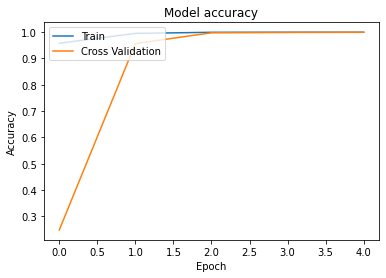

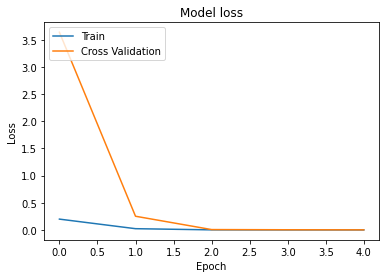

In [357]:
for h in histories:
    plot_history(h)

### Predicción

In [20]:
predictor = tf.keras.models.load_model('./best.hdf5')
predictor.summary()

ValueError: Unknown loss function: log_poisson_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [36]:
'''
    Foo
'''
def predict_wav(in_file, out_file, dir_path, predictor, sr=SAMPLING_RATE, inp_shape=INP_SHAPE, enc=mulaw_enc):
    
    # TO DO: Quitar comment
    #pianoroll = vectorize_midis([dir_path + in_file], sampling_rate=sr, dir_path=dir_path)[0]
    
    # Listas empleadas para el input/output del preductor
    in_arr = tf.random.uniform(inp_shape, minval=0, maxval=1, dtype=tf.dtypes.float32)
    lc_arr = []
    
    # Lista empleada para el output al fichero .wav
    wav_arr = tf.zeros([inp_shape[0]])
    
    # TO DO: Quitar [:]
    for i in tqdm(range(len(pianoroll[0:20000]))):
        
        # Getting the local conditioninng value for this step
        lc_arr = pianoroll[i]
        
        # Getting the value of the prediction
        prediction = predictor.predict({"seq": tf.expand_dims(in_arr, 0), \
                                        "lc": tf.expand_dims(tf.expand_dims(lc_arr, 0), 0)})[-1]
        prediction_idx = np.argmax(prediction[-1])
        
        # Figuring out the params for prediction in next step
        in_arr = tf.concat([in_arr[1:], tf.expand_dims(tf.keras.utils.to_categorical(prediction_idx, num_classes=N_LEVELS), 0)], 0)
        
        # Storing predicted values in wav format
        wav_arr = tf.concat([wav_arr, [enc.decode_sample(prediction_idx)]], 0)
        
    # Writting predicted series to file
    sf.write(dir_path + out_file, wav_arr, sr, 'PCM_24')
    
    return wav_arr


In [37]:
midi_hdlr = Midi_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH, n_notes=N_NOTES)
in_file = train_df['midi_filename'][0]
out_file = 'prediction.wav'
dir_path = './i\:o'

In [38]:
wav_arr = predict_wav(in_file, out_file, dir_path, model)

  1%|█▍                                                                                                                                                                                               | 145/20000 [00:26<1:00:36,  5.46it/s]


KeyboardInterrupt: 

In [27]:
pianoroll = (midi_hdlr.vectorize_midi(in_file) - MIDI_MIN) / (MIDI_MAX - MIDI_MIN)

In [28]:
print(pianoroll[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
